<a href="https://colab.research.google.com/github/geo-yrao/ML4ES-tutorials/blob/master/NCICS_ML_lecture_07_MASTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCICS ML Lesson 07: introduction to feature extraction with principal component analysis and decision tree-based classification methods

Welcome to Lesson 7 of the North Carolina Institute for Climate Studies' Machine Learning Course. In this session, we'll first explore the binary and multiclass datasets using principal component analysis (PCA) and then using a decision tree to classify them. NOTE: decision trees are rarely used on their own in machine learning, but they form the basis for several decision tree-based methods. Thus, we cover them in this lesson to lay the groundwork for future lessons.

## Session purpose:
The purpose of this session are two-fold. The first is to introduce you to PCA and decision tree classifiers. The second is to get you to start working a bit harder to understand how to code.  Correspondingly, these 

## Session contents:

### PCA:

(1) Set up + execution;

(2) Understanding and visualizing feature variance attributions (ie, the relative amount each PC contributes to overall variance);

(3) Why/when/how to trim to first several PCs;

### Decision trees:

(1) Set up + execution;

(2) Visualization of the decision boundaries in a 2-D (and maybe 3-D) feature space;

(3) Expand to multi-class, merging the first two classes and then renumbering the remaining classes;

(4) Evaluate a multiclass decision tree classifier and inspect its performance using a confusion matrix.

## About the data set:

The data set is actually satellite imagery of our home city of Asheville, taken from Landsat 8, an imaging satellite that was launched in 2013.  Check out the following links for more information:

[USGS Landsat Missions: Landsat 8](https://www.usgs.gov/land-resources/nli/landsat/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con)

[NASA Landsat Science: Landsat 8](https://landsat.gsfc.nasa.gov/landsat-data-continuity-mission/)

# Preprocess the data

We will be reusing the binary data set that we classified in Lesson 5. To prepare it for classification, we'll go through the same preprocessing steps as last time.

In [1]:
# Import all of the libraries that we'll be using.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import sklearn.metrics as skmetrics
import sklearn.model_selection as skmodel
import sklearn.preprocessing as skpreproc

# Import additional modules, objects, and functions that we'll use.
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Define the path and names of our data files.
path_data_dir =\
  "./ML4ES-tutorials/00-Data/"
filename_data = "NC_L8_GroundTruth.csv"

# Clone the data from Douglas' repo and then check which files are present.
try:
    ! git clone https://github.com/geo-yrao/ML4ES-tutorials.git
    ! ls $path_data_dir
except:
    ! ls $path_data_dir

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Cloning into 'ML4ES-tutorials'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 163 (delta 77), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (163/163), 1.69 MiB | 6.04 MiB/s, done.
Resolving deltas: 100% (77/77), done.
CDL_2017.tif  label_information.txt  NC_L8_GroundTruth.csv  README.md


## Ingest the data 

Class label information:

1.   **Class 0**: forest (includes data from cdl classes: 'forest', 'deciduous forest', 'evergreen forest', 'mixed forest');
2.   **Class 1**: corn (includes data from cdl class 'corn');
3.   **Class 2**: soy (includes data from cdl class 'soybeans');
4.   **Class 3**: developed/urban (includes data from cdl classes 'developed/open space', 'developed/low intensity', 'developed/med intensity', 'developed/high intensity');
5.   **Class 4**: water (includes data from cdl class 'open water').

In [2]:
# Use pandas's read_csv() function to import the data. Stipulate that the first column as the dataframe's index.
df_data = pd.read_csv(path_data_dir+filename_data, index_col=None)

# Delete the column named "Unnamed: 0", which were the row indices in the CSV.
df_data = df_data.drop(labels=["Unnamed: 0"], axis="columns")

# Isolate the data and the target values from the dataframe.
X = df_data.values[:, 3:]  # Data. The six L8 channels in the dataframe.
y = df_data.values[:, 2] # Target. The "class" column in the dataframe.

# Find the array indices for the forest and water samples in the dataset. Remember 
# that Python is 0-indexed, rather than 1-indexed like Fortran.
indices_samples_forest = np.where(y==0)
indices_samples_water = np.where(y==4)

# Create a binary data set of the data and the target for corn vs. urban pixels.
X_forest_vs_water = np.concatenate((X[indices_samples_forest], X[indices_samples_water]))
y_forest_vs_water = np.concatenate((y[indices_samples_forest], y[indices_samples_water]))

# Binarize the forest and water sample labels.
lb = skpreproc.LabelBinarizer()
y_binary = lb.fit_transform(y_forest_vs_water.tolist())

# Check on the dimensions for sanity.
print("Shape of binary data set:", X_forest_vs_water.shape)

# Use pandas DataFrame.head() function a look at the first five rows of the dataframe.
df_data.head()

Shape of binary data set: (875, 6)


,Latitude,Longitude,Class,B1,B2,B3,B4,B5,B6
0,35.514769,-82.680451,0,127,150,550,226,3609,1441
1,35.753979,-82.520432,0,81,115,426,170,2913,1110
2,35.710635,-82.305661,0,156,220,538,477,2492,2077
3,35.512814,-82.413861,0,245,280,663,507,2732,1531
4,35.520636,-82.853181,0,148,181,534,265,3320,1457


## Examining binary feature space using a scatterplot of the reflectance

As a refresher, we'll examine a few scatterplots of the binary data set. Band 2 includes light of the wavelengths 0.45 - 0.51 µm (<a href="https://www.wolframalpha.com/input/?i=0.45+%C2%B5m+color">violet</a>-to-<a href="https://www.wolframalpha.com/input/?i=0.51+%C2%B5m+color">light green</a>). Band 3 includes light of the wavelengths 0.53 - 0.59 µm (<a href="https://www.wolframalpha.com/input/?i=0.53+%C2%B5m+color">green</a>-to-<a href="https://www.wolframalpha.com/input/?i=0.59%C2%B5m+color">orange</a>). Band 4 includes light of the wavelengths 0.64 - 0.67 µm (red-to-deep-red). 

Recall that <a href="https://www.wolframalpha.com/"> Wolfram Alpha </a> is a quick and easy way to visualize spectra.

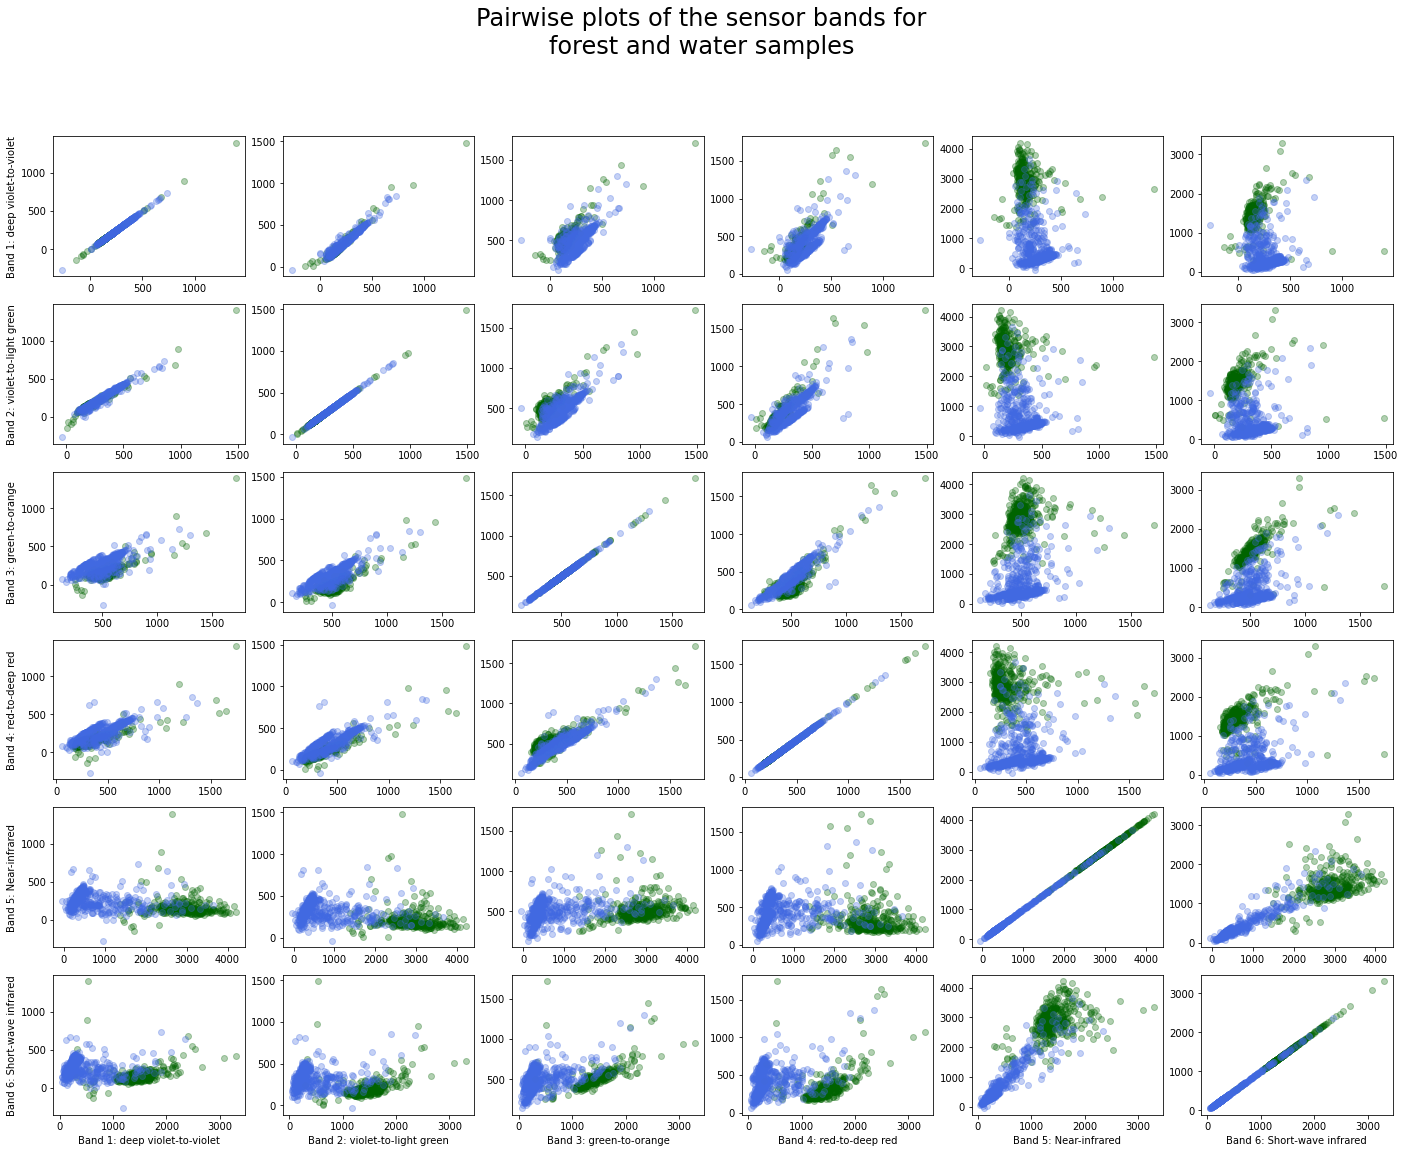

In [5]:
# Define a list of the class names to include in the plot.
class_labels_list = ["Forest", "Water"]

# Define a list of attractive colors to use in the notebook's data viz.
class_colors_list = ["darkgreen", "royalblue", ]

# Define a Python dictionary object to map the bands' column indices to their
# approximate color spectra names.
band_to_color_map = {
    0: "deep violet-to-violet",
    1: "violet-to-light green",
    2: "green-to-orange",
    3: "red-to-deep red",
    4: "Near-infrared",
    5: "Short-wave infrared",
}
num_bands = 6

# These are the indicies corresponding to the forest and water data,
# respectively, in our binary data set.
class_data_indices_list = [(0, 375), (375, 875)]

# Add some of the plotting aesthetic parameters.
alpha = 0.3

# Initialize a new matplotlib figure and its axes object.
fig, ax = plt.subplots(6, 6, figsize=(24, 18))

# Plot the forest and water samples' spectra to the scatter plot.
for i in range(num_bands):
    for j in range(num_bands):
        for k in range(2):
            idx_tuple = class_data_indices_list[k]
            ax[i, j].scatter(
                X_forest_vs_water[idx_tuple[0]:idx_tuple[1], i],
                X_forest_vs_water[idx_tuple[0]:idx_tuple[1], j],
                color=class_colors_list[k],
                alpha=alpha,
                label=class_labels_list[k],
            )

        # Add labels to the x- and y-axes.  
        if i==5:
            ax[i, j].set_xlabel(f"Band {j+1}: "+band_to_color_map[j])
        if j==0:
            ax[i, j].set_ylabel(f"Band {i+1}: "+band_to_color_map[i])

# Add a title to the figure.
fig.suptitle("Pairwise plots of the sensor bands for\nforest and water samples", fontsize=24)

# Show the plot. Google Colab and Jupyter Lab will do this anyways, but it's 
# good practice. And it avoids printed output from the penultimate line of code.
fig.show()

## Preprocessing: data exploration and feature engineering with principal component analysis (PCA) 

In this section, we will use Scikit-Learn's PCA capabilities to visually explore the binary data set.

### Plot the binary data set using the first two principal components


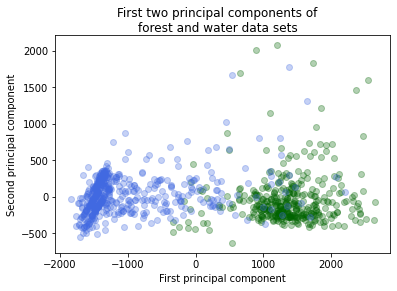

In [6]:
# Use scikit-learn's decomposition module's PCA object to transform the 
# forest-vs-water binary data set.
np.random.seed(7)
pca = decomposition.PCA(n_components=None)
X_pca = pca.fit_transform(X_forest_vs_water)

# These are the indicies corresponding to the forest and water data,
# respectively, in our binary data set.
class_data_indices_list = [(0, 375), (375, 875)]

# Loop through and scatter plot the first two principal components of the
# transformed binary data set.
fig, ax = plt.subplots()
for k in range(2):

    # Get the array indices of the current class.
    idx_tuple = class_data_indices_list[k]

    # Plot the first and second principal components of the current class.
    # Color and label the class appropriately. I modify the points' alpha b/c I
    # like how it looks.
    ax.scatter(
        X_pca[idx_tuple[0]:idx_tuple[1], 0],
        X_pca[idx_tuple[0]:idx_tuple[1], 1],
        color=class_colors_list[k],
        alpha=alpha,
        label=class_labels_list[k],
    )

# Add labels to the plot's x- and y-axises.
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")

# Add a title.
fig.suptitle("First two principal components of\nforest and water data sets")

# Display the figure.
fig.show()

### Three-dimensionally plot the binary data set using the first three principal components

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


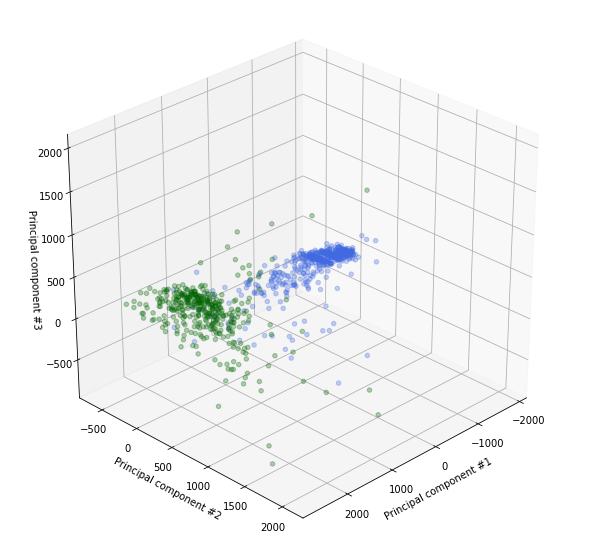

In [7]:
# Now loop through both classes and plot the first THREE principal components
# in a three-dimensional plot.
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(
    fig,
    rect=[0, 0, 1, 1.25],
    elev=30,
    azim=45
)
for k in range(2):
    idx_tup = class_data_indices_list[k]
    ax.scatter(
        X_pca[idx_tup[0]:idx_tup[1], 0],
        X_pca[idx_tup[0]:idx_tup[1], 1],
        X_pca[idx_tup[0]:idx_tup[1], 2],
        color=class_colors_list[k],
        alpha=alpha,
        label=class_labels_list[k],
    )

# Add x-, y-, and z-axises labels.
ax.set_xlabel("Principal component #1")
ax.set_ylabel("Principal component #2")
ax.set_zlabel("Principal component #3")

# Tidy up the plot.
plt.tight_layout()

# Display the plot.
fig.show()

### Pairwise plot the first three principal components of the binary data set

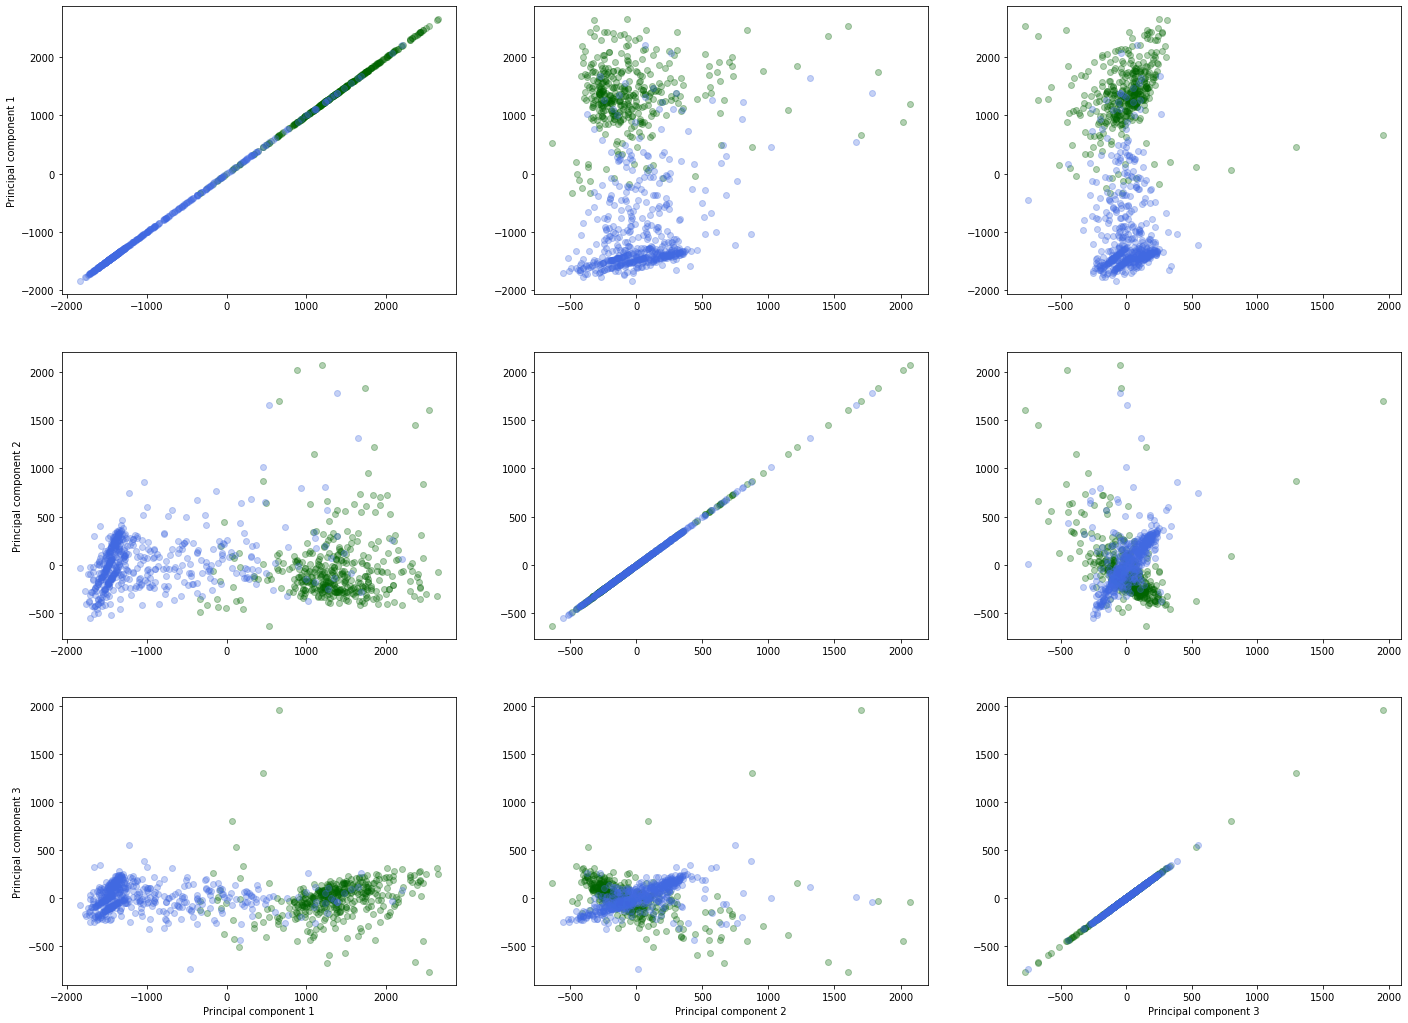

In [14]:
# Initialize a new matplotlib figure and its axes object.
fig, ax = plt.subplots(3, 3, figsize=(24, 18))

# Plot the forest and water samples' spectra to the scatter plot.
for i in range(3):
    for j in range(3):
        for k in range(2):
            idx_tup = class_data_indices_list[k]
            ax[j, i].scatter(
                X_pca[idx_tup[0]:idx_tup[1], i],
                X_pca[idx_tup[0]:idx_tup[1], j],
                color=class_colors_list[k],
                alpha=alpha,
                label=class_labels_list[k],
            )
          
        if i==2:
            ax[i, j].set_xlabel(f"Principal component {j+1}")
        if j==0:
            ax[i, j].set_ylabel(f"Principal component {i+1}")
fig.show()

### Plot the explained variance ratio as a function of the principal component

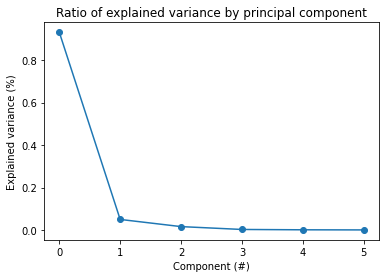

In [ ]:
# Scikit-learn's PCA objects have a handy pca.explained_variance_ratio_ attribute
# that you can use.
fig, ax = plt.subplots()
ax.plot(
    [i for i in range(len(pca.explained_variance_ratio_))],
    pca.explained_variance_ratio_,
    ".-",
    markersize=12,
)
ax.set_xlabel("Component (#)")
ax.set_ylabel("Explained variance (%)")
ax.set_title("Ratio of explained variance by principal component")

fig.show()

In [ ]:
# Calculate and print the amount of variance that the first three components
# account for (as a percentage of total variance).
print("First three components account for", np.round(100*sum(pca.explained_variance_ratio_[:3]), 3), "% of the variance.")

First three components account for 99.71 % of the variance.


# Binary classification using decision trees

Here, we'll use scikit-learn's decision tree classifier to build a 

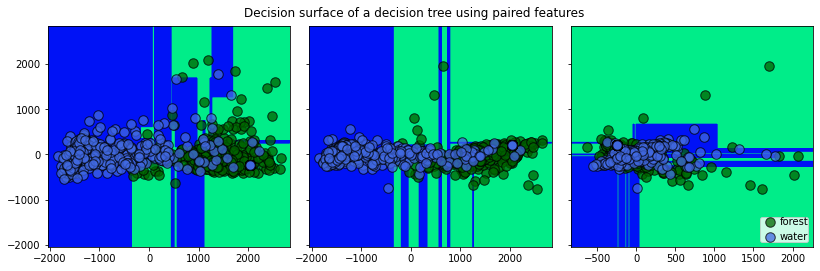

In [ ]:
# Fit/PCA transform for the binary forest-v-water data set..
np.random.seed(7)
pca = decomposition.PCA(n_components=None)
X_pca = pca.fit_transform(X_forest_vs_water)

# Set some of the plotting parameters.
plot_step = 20  # The step size between grid points for the plotting the decision boundaries.
n_classes = 2  # Number of classes to plot.
plotting_pad = 200 # The amount to pad the plot boundaries.
class_labels_list = ["forest", "water"]
class_colors_list = ["darkgreen", "royalblue"]

# Calculatet the max and min for the shared y-axis. 
X = X_pca[:, :3]
y_min, y_max = X[:, :3].min() - plotting_pad, X[:, :3].max() + plotting_pad
y = y_binary

# Loop through pairs of the first three principal components and scatter plot them pairwise
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for pairidx, pair in enumerate([[0, 1], [0, 2], [1, 2],]):

    # Subset to the specified pair of PCA components.
    X = X_pca[:, pair]

    # Train the decision tree classifier.
    oak = DecisionTreeClassifier().fit(X, y)

    # Calculate the x-axis limits for the current two components and make the plots
    # a bit prettier.
    x_min, x_max = X[:, 0].min() - plotting_pad, X[:, 0].max() + plotting_pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    # Feed the 2-D grid points into the classifier and have it predict their classes.
    # Then use matplotlib's contourf() plot method to visualize these decision regions.
    Z = oak.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax[pairidx].contourf(xx, yy, Z, cmap=plt.cm.winter_r)

    # Scatter plot the training points over top of the decision regions.
    for i, color in zip(range(n_classes), class_colors_list):
        idx = np.where(y == i)
        ax[pairidx].scatter(X[idx, 0], X[idx, 1], c=color, label=class_labels_list[i],
                    cmap=plt.cm.winter_r, edgecolor='black', s=90, alpha=0.75)

# Add a title and a legend. 
fig.suptitle("Decision surface of a decision tree using paired features")
ax[2].legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight"); 

# Multiclass classification with decision trees

Now we'll step into the world of multiclass classification.  Since corn and soy have somewhat similar spectral signatures, we'll combine them into a single class. 

Here's the class label information again:

1.   **Class 0**: forest (includes data from cdl classes: 'forest', 'deciduous forest', 'evergreen forest', 'mixed forest');
2.   **Class 1**: corn (includes data from cdl class 'corn');
3.   **Class 2**: soy (includes data from cdl class 'soybeans');
4.   **Class 3**: developed/urban (includes data from cdl classes 'developed/open space', 'developed/low intensity', 'developed/med intensity', 'developed/high intensity');
5.   **Class 4**: water (includes data from cdl class 'open water').

First three components account for 99.659 % of the variance.


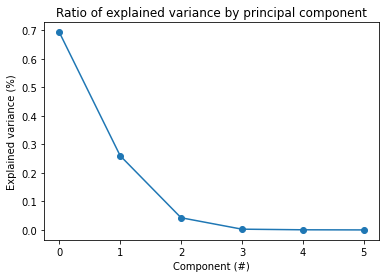

In [ ]:
# Isolate the data and the target values from the dataframe.
X = df_data.values[:, 3:]  # Data. The six L8 channels in the dataframe.
y = df_data.values[:, 2] # Target. The "class" column in the dataframe.

np.random.seed(7)
pca = decomposition.PCA(n_components=None)
X_pca = pca.fit_transform(df_data.values[:, 3:])

# Plot the explained variance ratio for the multiclass data set.
fig, ax = plt.subplots()
ax.plot(
    [i for i in range(len(pca.explained_variance_ratio_))],
    pca.explained_variance_ratio_,
    ".-",
    markersize=12,
)
ax.set_xlabel("Component (#)")
ax.set_ylabel("Explained variance (%)")
ax.set_title("Ratio of explained variance by principal component")

print(
    "First three components account for",
    np.round(100*sum(pca.explained_variance_ratio_[:3]), 3),
    "% of the variance."
)

As you can see above, the variance in the multiclass data set distributed among the first several components, rather than being as heavily concentrated in the first component (as it was in the binary forest-v-water case).

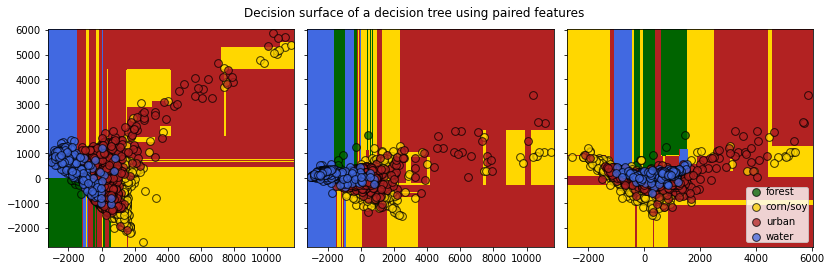

In [ ]:
# Define some plotting parameters and relevant lists.
plot_step = 20
plotting_pad = 200
multiclass_colors_list = ["darkgreen","gold", "firebrick", "royalblue"]
multiclass_labels_list = ["forest", "corn/soy", "urban", "water"]

# Initialize a three-panel figure upon which we will plot the decision boundaries.
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# Calculate the limits of the shared y-axis. 
# Again, this is to make the plot look pretty.
X_pca_all = X_pca[:, :3]
y_min, y_max = X_pca_all[:, 1].min() - plotting_pad, X_pca_all[:, 1].max() + plotting_pad

# Merge together the two crop classes (corn and soy) and renumber the rest of the
# classes appropriately.
y = df_data.values[:, 2]
y_merged = np.array([i if i < 2 else i-1 for i in y])
n_classes = len(np.unique(y_merged))

# Define a new matplotlib colormap using the list of multiclass colors.
# We'll use this colormap on the decision regions' plots.
newcmap = ListedColormap(multiclass_colors_list)

# Loop through the first three principal components and plot them pairwise,
# along with their decision regions, for the multiclass data sets.
for pairidx, pair in enumerate([[0, 1], [0, 2], [1, 2],]):
    
    # Subset down to the relevant principal component pair.
    X_pca_pair = X_pca[:, pair]

    # Train the decision tree classifier.
    hemlock = DecisionTreeClassifier().fit(X_pca_pair, y_merged)

    x_min, x_max = X_pca_pair[:, 0].min() - plotting_pad, X_pca_pair[:, 0].max() + plotting_pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = hemlock.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax[pairidx].contourf(xx, yy, Z, cmap=newcmap)

    # Plot the training points
    for i, color in zip(range(n_classes), multiclass_colors_list):
        idx = np.where(y_merged == i)
        ax[pairidx].scatter(X_pca_pair[idx, 0], X_pca_pair[idx, 1], c=color, label=multiclass_labels_list[i], edgecolor='black', s=60, alpha=0.75)

fig.suptitle("Decision surface of a decision tree using paired features")
ax[2].legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight");
fig.show();



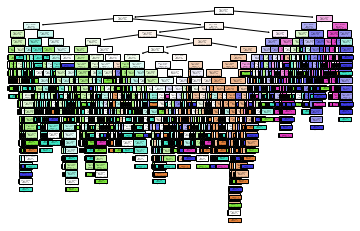

In [ ]:
# Display the structure of the decision tree using scikit-learn's plot_tree function.
plt.figure()
poplar = DecisionTreeClassifier().fit(X_pca_all, y)
plot_tree(poplar, filled=True,)
plt.show()

# Evaluate the performance of a decision tree classifier on the multiclass data set.

In [ ]:
# Re-isolate the data and the target values from the dataframe. This is 
X = df_data.values[:, 3:]  # Data. The six L8 channels in the dataframe.
y = df_data.values[:, 2] # Target. The "class" column in the dataframe.
y_merged = np.array([i if i < 2 else i-1 for i in y]) # Merge the crop classes.

# Initialize a decision tree classifier object. We'll train it and then have it predict the
# classes of withheld testing samples.
maple = DecisionTreeClassifier()

# Initialize a stratified 10-fold generator for the cross-validation.
stratified_kfold_generator = StratifiedKFold(n_splits=10, random_state=7)

# Iterate through each of the splits and train/test the decision tree classifier. We will 
# store the predictions in the following list, "classfication predictions".
classification_predictions = list()
for train, test in stratified_kfold_generator.split(X, y_merged):

    # Create a new PCA object, fit it to the training data, and then transform the training data.
    np.random.seed(7)
    pca = decomposition.PCA(n_components=None)
    X_pca_train = pca.fit_transform(X[train])

    # Fit the classifier to the PCA'ed training data. This erases the training 
    # from any previous iteration of the loop.
    maple.fit(X_pca_train, y_merged[train].ravel())

    # Have the newly trained classifier predict the classes of the withheld
    # Be sure to transform the testing data using the PCA object that was
    # previously fit to the training data.
    y_predicted = maple.predict(pca.transform(X[test]))

    # Add the true class labels and the predicted class labels to the storage list.
    classification_predictions.append((y_merged[test].ravel(), y_predicted.ravel()))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


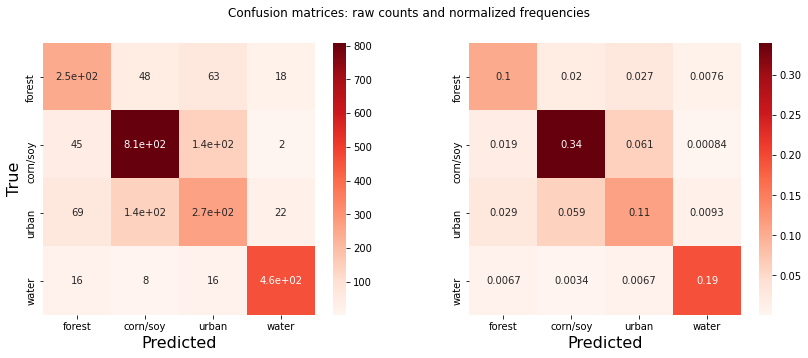

In [ ]:
# Loop through the cached predictions and calculate the aggregate confusion matrix,
# both with the raw counts and another that is normalized by the total number of samples.
cf = np.zeros((4,4))
for y_true, y_pred in classification_predictions:
    cf += confusion_matrix(y_true, y_pred)
cf_normalized = cf/cf.sum()

# Initialize figure, axes for the two confusion matrices.
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the raw counts' confusion matrix.
seaborn.heatmap(
    cf, cmap="Reds", annot=cf, square=True, cbar=True,
    xticklabels=multiclass_labels_list, yticklabels=multiclass_labels_list,
    ax=ax[0]
)

# Add labels to the x-axis and the y-axis.
ax[0].set_xlabel("Predicted", fontsize=16)
ax[0].set_ylabel("True", fontsize=16)

# Plot the percentages' confusion matrix.
seaborn.heatmap(
    cf_normalized, cmap="Reds", annot=True, square=True,
    xticklabels=multiclass_labels_list, yticklabels=multiclass_labels_list,
    ax=ax[1]
)

# Add a label to the x-axis.
ax[1].set_xlabel("Predicted", fontsize=16)

# Add a title to the figure.
fig.suptitle("Confusion matrices: raw counts and normalized frequencies")

# Display the figure.
fig.show()